# Hierarchical MCMC


In [105]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy

import pints
import pints.toy as toy

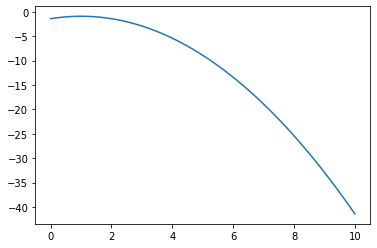

-41.418938533204674

In [90]:
# Parameters (& hyper parameters)
theta_data = [28, 8, -3, 7, -1, 1, 18, 12] # measured average score for each school
sigma_data = [15, 10, 16, 11, 9, 11, 10, 18] # measured score SD for each school
mu = 1 # overall mean score
tau = 1 # overall score SD

# What is gaussianlogprior?
prior = pints.GaussianLogPrior(mu, tau)
nums = [n/10 for n in np.linspace(0,100)]
test = [prior([n]) for n in nums]
plt.figure()
plt.plot(nums, test)
plt.show()

prior([10])

For our case, the probability is 
$$\begin{eqnarray}
\mathcal{P} &=& P(y_j, \theta_j, \mu, \tau) 
\\&=& \prod_{j=1}^8 P(y_j|\theta_j,\sigma_j) \cdot P(\theta_j|\mu,\tau) \cdot P(\mu) \cdot P(\tau)
\\&=& \prod_{j=1}^8 N(\theta_j,\sigma_j) \cdot N(\mu,\tau) \cdot N(\mu_\mu,\sigma_\mu) \cdot C(\mu_\tau, \sigma_\tau)
\\&=& \prod_{j=1}^8 \Bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}} \cdot \frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}} \cdot \frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}} \cdot \frac{\sigma_\tau^2}{(\tau-\mu_\tau)^2 + \sigma_\tau^2} \Bigg)
\end{eqnarray}$$

And so the log probability is  
$$\begin{eqnarray}
\log\mathcal{P} = \mathcal{L} &=& \log\bigg(\sum_{j=1}^8 P(y_j|\theta_j,\sigma_j)P(\theta_j|\mu,\tau)P(\mu)P(\tau)\bigg)
\\&=& \sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}}\bigg)
+ \sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}\bigg)
+ \log\bigg(\frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}\bigg)
+ \log\bigg(\frac{1}{\sqrt{2\pi\sigma_\tau^2}}e^{\frac{-(\mu-\mu_\tau)^2}{2\sigma_\tau^2}}\bigg)
\end{eqnarray}$$

Note that the exponentials can be further separated from the fractions if required, using the log sum law: $\log(ab) = \log(a)+\log(b)$

In [91]:
# Stolen mostly from pints eightschools

def loglikelihood_8schools(x, y_data):
    # x is proposed parameters, we're finding numerator of Bayes' rule
    if len(x) != 10:
        raise ValueError('Input parameters must be of length 10.')
    mu = x[0] # overall mean
    tau = x[1] # overall variance
    thetas = x[2:] # mean per school
    lk_of_theta = 0
    lk_of_data = 0
    # priors
    log_prior = pints.GaussianLogPrior(mu, tau) # prior pdf of theta
    mu_log_prior = pints.GaussianLogPrior(0,5) # prior pdf, centred on zero (no avg effect)
    tau_log_prior = pints.HalfCauchyLogPrior(0,5) # prior pdf, why centre zero???
    
    lk_of_mu = mu_log_prior([mu]) # log likelihood of mu
    lk_of_tau = tau_log_prior([tau]) # log likelihood of tau

    # nb. theta_tilde is the proposed theta (rather than data theta) I think?
    for i, theta_tilde in enumerate(thetas): # go through each proposed school mean
        lk_of_theta += log_prior([theta_tilde]) # log likelihood of theta

        log_prior_2 = pints.GaussianLogPrior(theta_tilde, sigma_data[i]) 
        lk_of_data += log_prior_2([y_data[i]]) # log likelihood of data given theta?

    return lk_of_mu + lk_of_tau + lk_of_theta + lk_of_data


In [92]:
# Let's compare this to pints to make sure it works
customtest = loglikelihood_8schools(np.ones(10), theta_data)
pintsmodel = toy.EightSchoolsLogPDF()
pintstest = pintsmodel(np.ones(10))

Some MCMC techniques use the local gradient to choose the next step size, so we need the sensitivity of the log probability with respect to each parameter. `evaluateS1` returns the LogPDF, plus the partial derivatives of the LogPDF with respect to the parameters. The partial derivatives in this case are given here.  

Only two terms of $\log\mathcal{L}$ have $\mu$ in; the rest differentiate to zero so can be ignored.

$$\begin{eqnarray}\require{cancel}
\frac{\partial \mathcal{L}}{\partial \mu} &=& \cancel{\sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}}\bigg)}
+ \sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}\bigg)
+ \log\bigg(\frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}\bigg)
+ \cancel{\log \bigg( \frac{\sigma_\tau^2}{(\tau-\mu_\tau)^2 + \sigma_\tau^2} \bigg)}
\\&=& \frac{\partial}{\partial \mu} \bigg( \cancel{\log \frac{1}{\sqrt{2\pi\tau^2}}} + \log(e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}) + \cancel{\log \frac{1}{\sqrt{2\pi\sigma_\mu^2}}} + \log(e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}) \bigg)
\\&=& \frac{\partial}{\partial \mu} \bigg( \log(e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}) + \log(e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}) \bigg)
\\&=& \frac{\partial}{\partial \mu} \bigg(\frac{-(\theta_j-\mu)(\theta_j-\mu)}{2\tau^2} + \frac{-(\mu-\mu_\mu)(\mu-\mu_\mu)}{2\sigma_\mu^2}\bigg)
\\&=& \frac{1}{2\tau^2} \frac{\partial}{\partial \mu} \bigg(-(\theta_j-\mu)(\theta_j-\mu)\bigg) + \frac{1}{2\sigma_\mu^2} \frac{\partial}{\partial \mu} \bigg(-(\mu-\mu_\mu)(\mu-\mu_\mu)\bigg)
\\&=& \frac{-2\theta_j+2\mu}{2\tau^2} + \frac{-2\mu+2\mu_\mu}{2\sigma_\mu^2}
\\&=& \frac{\mu-\theta_j}{\tau^2} + \frac{\mu_\mu-\mu}{\sigma_\mu^2}
\end{eqnarray}$$

$\theta$ can be calculated the same way as above (for each j).

$$\begin{eqnarray}
\frac{\partial \mathcal{L}}{\partial \theta_j} &=& \frac{\partial}{\partial \theta_j}\bigg( \log e^{\frac{-(\theta_j-\mu)^2}{2\sigma_j^2}}\bigg) + \frac{\partial}{\partial \theta_j}\bigg( \log e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}} \bigg)
\\&=& \frac{\partial}{\partial \theta_j}\bigg({\frac{-(\theta_j-\mu)(\theta_j-\mu)}{2\sigma_j^2}}\bigg) + \frac{\partial}{\partial \theta_j}\bigg({\frac{-(y_j-\theta_j)(y_j-\theta_j)}{2\sigma_j^2}} \bigg)
\\&=& \frac{\theta_j-y_j}{\sigma_j^2} + \frac{\mu-\theta_j}{\tau^2}
\end{eqnarray}$$  

I'll split $\tau$ into two parts, so as to simplify the working. Part 1 is the probability of the estimated results, $\theta_j$, given $\tau$. Here we use the chain rule, $\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial x}$ with $z=\frac{1}{\sqrt{2\pi\tau^2}}$.
Note that I have an additional minus sign here on line 4 that I can't seem to locate the origin of. If found please return.

$$\begin{eqnarray}
\frac{\partial \mathcal{L}1}{\partial \tau} &=& \frac{\partial}{\partial \tau}\bigg( \log\frac{1}{\sqrt{2\pi\tau^2}} + \log e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}} \bigg)
\\&=& \frac{\partial}{\partial z} \log z \cdot \frac{\partial}{\partial \tau} \frac{1}{\sqrt{2\pi\tau^2}} + \frac{\partial}{\partial \tau} {\frac{-(\theta_j-\mu)^2}{2\tau^2}}
\\&=& \bigg(\sqrt{2\pi\tau^2}\bigg)\bigg(\frac{1}{\tau^2\sqrt{2\pi}}\bigg) + \frac{(\theta_j-\mu)^2}{\tau^3}
\\&=&\frac{(\theta-\mu)^2}{\tau^3} - \frac{1}{\tau}
\\&=&\frac{(\theta-\mu)^2-\tau^2}{\tau^3}
\end{eqnarray}$$  

Part 2 is the probability of $\tau$ given the underlying probability distribution (chosen by the modeller). In this case we're using a half-Cauchy distribution centred on a mean that I have (foolishly) called $\mu_\tau$ with a variance (kind of: not technically a variance but whatever) of $\sigma_\tau$. This is a fun one as it uses both the chain rule and the quotient rule for differentiation. I bet you never thought you'd be revising those today.

$$\begin{eqnarray}
\frac{\partial \mathcal{L}2}{\partial \tau} &=& \frac{\partial}{\partial \tau} \log \bigg( \frac{\sigma_\tau^2}{(\tau-\mu)^2 + \sigma_\tau^2} \bigg)
\\&=& \frac{\partial}{\partial z} \cdot \log (z) \frac{\partial}{\partial \tau} \bigg( \frac{\sigma_\tau^2}{(\tau-y_\tau)^2 + \sigma_\tau^2} \bigg) \ where \ z = \frac{\sigma_\tau^2}{(\tau-\mu_\tau)^2 + \sigma_\tau^2}
\\&=& \frac{(\tau-\mu_\tau)^2 + \sigma_\tau^2}{\sigma_\tau^2} \cdot \sigma_\tau^2 \cdot \frac{\partial}{\partial \tau} \bigg( \frac{1}{(\tau-\mu_\tau)^2 + \sigma_\tau^2} \bigg)
\\&=& ((\tau-\mu_\tau)^2 + \sigma_\tau^2) \cdot \frac{2\tau-2\mu_\tau}{((\tau-\mu_\tau)^2 + \sigma_\tau^2)^2}
\\&=& \frac{2\tau-2\mu_\tau}{(\tau-\mu_\tau)^2 + \sigma_\tau^2}
\\ \frac{\partial \mathcal{L}}{\partial \tau} &=& \frac{(\theta-\mu)^2-\tau^2}{\tau^3} + \frac{2\tau-2\mu_\tau}{(\tau-\mu_\tau)^2 + \sigma_\tau^2}
\end{eqnarray}$$  

In [93]:
np.array(n+1 for n in range(10))

array(<generator object <genexpr> at 0x7fb67e4bfad0>, dtype=object)

In [94]:
# We'll make a logPDF class, and use th equations above in evaluateS1.
class pints8schools(pints.LogPDF):
    def __init__(self):
        self._n_parameters = 10
    def __call__(self, x, y_data=theta_data): 
        return loglikelihood_8schools(x, y_data)
    def n_parameters(self):
        return self._n_parameters
    def evaluateS1(self, x):
        mu = x[0]
        tau = x[1]
        thetas = x[2:]
        ys = theta_data
        sigmas = sigma_data
        
        logprob = loglikelihood_8schools(x, ys)
        
        dLdmu = (0-mu)/(5**2)
        dLdtau = (-2*tau)/(tau**2 + 5**2) 
        dLdtheta = []
        
        for j in range(len(thetas)):
            theta = thetas[j]
            y_j = ys[j]
            sigma = sigmas[j]
            dLdmu += (theta-mu)/(tau**2)
            dLdtau += ((theta-mu)**2)/tau**3 - 1/tau
            dLdtheta.append((-(theta-y_j)/sigma**2) + (mu-theta)/tau**2)
        
        return logprob, ([dLdmu] + [dLdtau] + dLdtheta)

ls = [list(n+1 for n in range(10)), list(np.ones(10))]
print(ls)
start_thetas = [arr for arr in ls]
model = pints8schools()
pintsmodel = toy.EightSchoolsLogPDF()

pintstest1, pintstest2 = pintsmodel.evaluateS1(start_thetas[0])
test1, test2 = model.evaluateS1(start_thetas[0])
print('pints: %.9f  mine: %.9f logprob' % (pintstest1, test1))
for n in range(len(test2)):
    print('pints: %.10f  mine: %.10f' % (pintstest2[n], test2[n]))

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
pints: -83.081942061  mine: -83.081942061 logprob
pints: 10.9600000000  mine: 10.9600000000
pints: 31.3620689655  mine: 31.3620689655
pints: -0.3888888889  mine: -0.3888888889
pints: -0.7100000000  mine: -0.7100000000
pints: -1.0312500000  mine: -1.0312500000
pints: -1.2417355372  mine: -1.2417355372
pints: -1.5987654321  mine: -1.5987654321
pints: -1.8078512397  mine: -1.8078512397
pints: -1.9100000000  mine: -1.9100000000
pints: -2.2438271605  mine: -2.2438271605


In [95]:
mcmc = pints.MCMCController(model, 2, start_thetas, method=pints.HamiltonianMCMC)
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

full_chains = mcmc.run()

Using Hamiltonian Monte Carlo
Generating 2 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Time m:s
0     2      0         0          0:00.0
1     42     0.333     0.333      0:00.0
2     82     0.5       0.5        0:00.1
3     122    0.6       0.6        0:00.1
100   4002   0.98      0.98       0:01.3
200   8002   0.990099  0.990099   0:02.6
300   12002  0.993     0.993      0:04.1
400   16002  0.995     0.995      0:05.8
500   20002  0.996     0.996      0:07.0
600   24002  0.997     0.997      0:08.5
700   28002  0.997151  0.997151   0:09.7
800   32002  0.998     0.998      0:10.4
900   36002  0.998     0.998      0:11.2
1000  40002  0.998004  0.998004   0:12.0
1100  44002  0.998     0.998      0:12.9
1200  48002  0.998     0.998      0:14.1
1300  52002  0.998     0.998      0:14.8
1400  56002  0.999     0.999      0:15.6
1500  60002  0.999     0.999      0:16.4
1600  64002  0.999     0.999      0:17.1
1700  68002  0.999     0.999      0:17.8
1800  72002  0.999 

In [96]:
# Let's do a basic check that it works.
print(model(start_thetas[0]))
model1 = toy.EightSchoolsLogPDF()
print(model1(start_thetas[0]))

-83.08194206143219
-83.08194206143219


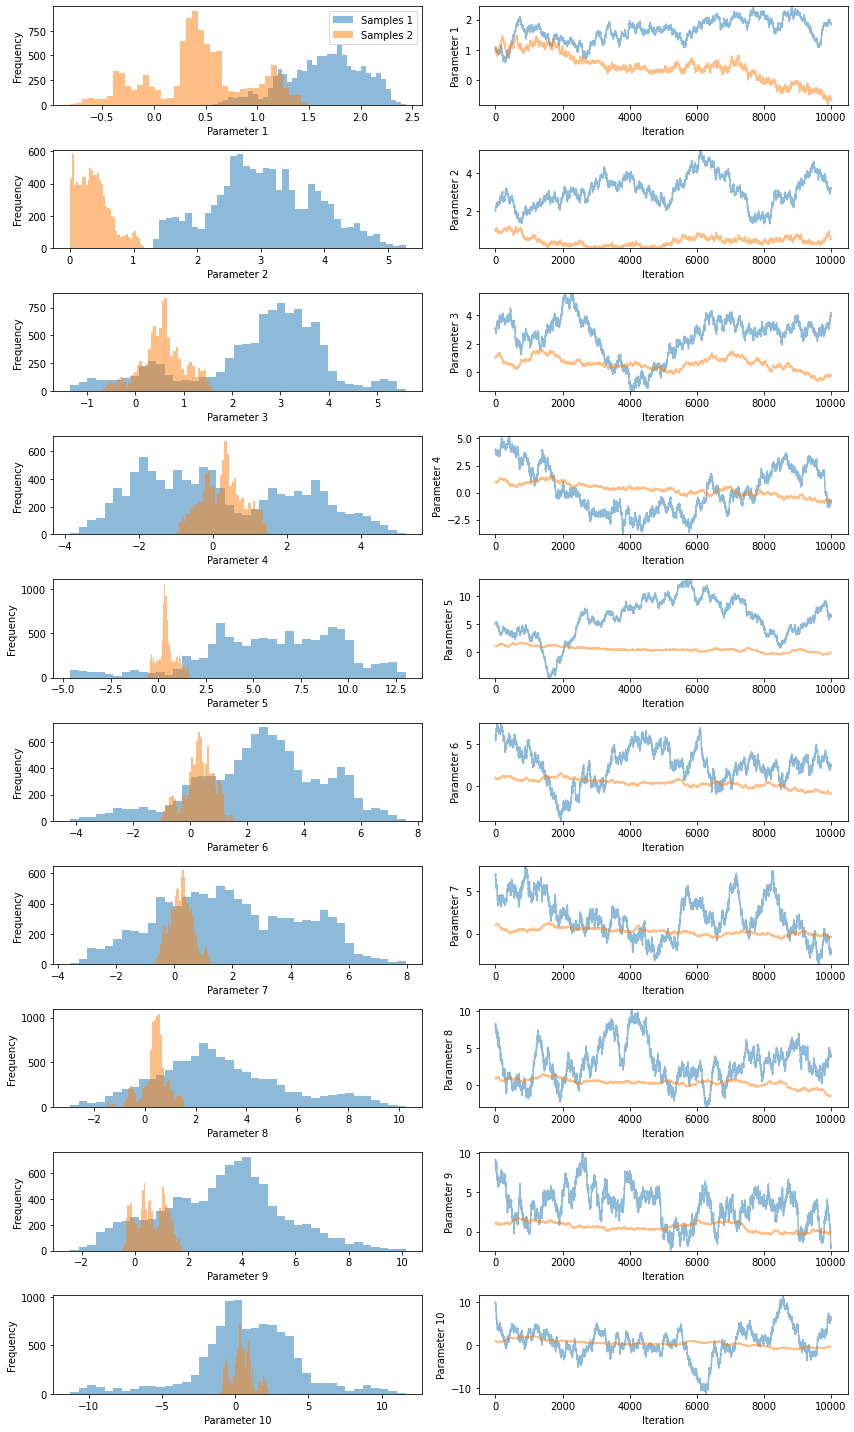

In [97]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

# Making a non-centred model

Our school-level score means come from a normal distribution, $\theta \sim N(\mu, \tau)$. But this sometimes doesn't work SOMETHING SOMETHING SMETHING

In a non-centred model, school-level means instead come from a normal distribution whose mean and variance is fixed, $N(0, 1)$. In the same way as how you modify any distribution, you can modify how far this distribution stretches with a multiplier, and modify where it is centred with an addend (that's the name, I googled it, don't judge me!). 

i.e.
$$\theta = \mu + z \cdot \tau
\\ z \sim N(0, 1)$$
Where $\theta$ is the school-level mean, $\mu$ is the overall mean (mean of means), $z$ comes from this normal distribution (resampled for each new theta) and $\tau$ is the overall variance. In this way, $\theta$ is the same (because $\mu + N(0,1) \cdot \tau \equiv N(\mu, \tau)$) but it relies on an independent variable, $z$.

So our overall probability is:-
$$ \begin{eqnarray}
\mathcal{P} &=& \prod_{j=1}^8 P(y_j|\theta_j,\sigma_j) \cdot P(z_j) \cdot P(\mu) \cdot P(\tau)
\\&=& \prod_{j=1}^8 \Bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-(z\tau + \mu))^2}{2\sigma_j^2}} \cdot \frac{1}{\sqrt{2\pi(1)^2}}e^{\frac{-(z_j-0)^2}{2(1)^2}} \cdot \frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}} \cdot \frac{\sigma_\tau^2}{(\tau-\mu_\tau)^2 + \sigma_\tau^2} \Bigg)
\end{eqnarray}$$

But wait! There's more! We'll need the partial derivatives with respect to $\mu$, $\tau$, and $z_j$. Fortunately these are easier than you'd think: the first term can be differentiated using the chain rule with the function we already have, $\theta = \mu + z \cdot \tau$.

$$ \begin{eqnarray}
\frac{\partial}{\partial z_j} \frac{-(y_j-(z_j\tau + z_j))^2}{2\sigma_j^2} &= \frac{\partial}{\partial \theta_j} \frac{-(y_j-\theta_j)^2}{2\sigma_j^2} \cdot \frac{\partial}{\partial z_j} (z_j\tau+\mu)
\\&= \frac{\theta_j-y}{\sigma_j^2} \cdot \tau
\end{eqnarray}$$

And by the same working,
$$ \begin{eqnarray}
\frac{\partial}{\partial \tau} \frac{-(y_j-(z_j\tau + \mu))^2}{2\sigma_j^2} &= \frac{\theta_j-y_j}{\sigma_j^2} \cdot z_j
\\ \frac{\partial}{\partial \mu} \frac{-(y_j-(z_j\tau + \mu))^2}{2\sigma_j^2} &= \frac{\theta_j-y_j}{\sigma_j^2}
\end{eqnarray}$$

So the derivatives of the log likelihoods are, from the working here and previously:-
$$ 
\frac{\partial\mathcal{L}}{\partial \mu} = \frac{\theta_j-y_j}{\sigma_j^2} + \frac{\mu_\mu-\mu}{\sigma_\mu^2}
$$

$$
\frac{\partial\mathcal{L}}{\partial \tau} = z_j \frac{\theta_j-y_j}{\sigma_j^2} + \frac{\mu_\tau-\tau}{\sigma_\tau^2}
$$

$$
\frac{\partial\mathcal{L}}{\partial z_j} = \tau \frac{\theta_j-y_j}{\sigma_j^2} -z_j
$$

In [98]:
# Calculations with non-centred model as above
# Comments indicate changes

def loglikelihood_8schools_nc(x, y_data):
    # x is proposed parameters, we're finding numerator of Bayes' rule
    if len(x) != 10:
        raise ValueError('Input parameters must be of length 10.')
    mu = x[0] 
    tau = x[1] 
    thetas = x[2:] 
    lk_of_z = 0
    lk_of_data = 0
    # priors
    z_log_prior = pints.GaussianLogPrior(0, 1) # CHANGED 
    mu_log_prior = pints.GaussianLogPrior(0,5) 
    tau_log_prior = pints.HalfCauchyLogPrior(0,5) 
    
    lk_of_mu = mu_log_prior([mu]) 
    lk_of_tau = tau_log_prior([tau]) 

    # nb. z is the proposed z
    for i, z in enumerate(thetas): 
        lk_of_z += z_log_prior([z]) # CHANGED
        theta = z*tau + mu # ADDED
        y_log_prior = pints.GaussianLogPrior(theta, sigma_data[i]) # CHANGED
        lk_of_data += y_log_prior([y_data[i]]) 

    return lk_of_mu + lk_of_tau + lk_of_z + lk_of_data


class pints8schools_nc(pints.LogPDF):
    def __init__(self):
        self._n_parameters = 10
    def __call__(self, x, y_data=theta_data): 
        return loglikelihood_8schools_nc(x, y_data)
    def n_parameters(self):
        return self._n_parameters
    def evaluateS1(self, x):
        mu = x[0]
        tau = x[1]
        zs = x[2:]
        ys = theta_data
        sigmas = sigma_data
        
        logprob = loglikelihood_8schools_nc(x, ys)
        
        dLdmu = (0-mu)/(5**2)
        dLdtau = (-2*tau)/(tau**2 + 5**2) 
        dLdz = []
        
        for j in range(len(zs)):
            z = zs[j]
            y_j = ys[j]
            sigma = sigmas[j]
            theta = z*tau + mu
            dLdmu += (y_j-theta)/sigma**2
            dLdtau += z * (y_j-theta)/sigma**2 # CHANGED
            dLdz.append((tau*(y_j-theta)/sigma**2) - z) # CHANGED
        
        return logprob, ([dLdmu] + [dLdtau] + dLdz)

In [99]:
# Test it

ls = [abs(np.random.normal(size=10)) for n in range(4)]
print(ls)
start_thetas = [arr for arr in ls]
model = pints8schools_nc()
pintsmodel = toy.EightSchoolsLogPDF(centered=False)

pintstest1, pintstest2 = pintsmodel.evaluateS1(start_thetas[0])
test1, test2 = model.evaluateS1(start_thetas[0])
print('pints: %.9f  mine: %.9f logprob' % (pintstest1, test1))
for n in range(len(test2)):
    print('pints: %.10f  mine: %.10f' % (pintstest2[n], test2[n]))

[array([0.50376331, 0.15674865, 2.57160894, 0.97682001, 1.08014679,
       0.38626394, 0.31000236, 0.38559168, 0.87997396, 0.219753  ]), array([0.73416342, 1.91400106, 0.58897814, 0.42743822, 0.58141162,
       0.56511428, 0.20029901, 0.96570084, 0.37108844, 2.3036748 ]), array([0.33994379, 2.07530815, 0.08633935, 1.32588812, 0.25938156,
       0.28518935, 0.90481911, 1.05048519, 2.97265717, 1.40689837]), array([0.00861963, 0.21677211, 0.16903209, 1.86012365, 0.32671677,
       0.00932865, 1.51990781, 1.4015953 , 0.92723153, 1.11170331])]
pints: -48.066266828  mine: -48.066266828 logprob
pints: 0.4059298633  mine: 0.4059298633
pints: 0.5298757313  mine: 0.5298757313
pints: -2.5527342110  mine: -2.5527342110
pints: -0.9653097634  mine: -0.9653097634
pints: -1.0823958152  mine: -1.0823958152
pints: -0.3779268636  mine: -0.3779268636
pints: -0.3130064291  mine: -0.3130064291
pints: -0.3850271347  mine: -0.3850271347
pints: -0.8527650560  mine: -0.8527650560
pints: -0.2142078761  mine: -0.

In [103]:
mcmc = pints.MCMCController(model, 4, start_thetas, method=pints.HamiltonianMCMC)
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)
mcmc.set_max_iterations(1000)

full_chains = mcmc.run()

Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0          0:00.0
2     164    0.5       0.5       0.5       0.25       0:00.1
3     244    0.6       0.6       0.6       0.4        0:00.1
100   8004   0.941     0.892     0.98      0.971      0:01.6
200   16004  0.955     0.946     0.960396  0.985      0:03.5
300   24004  0.97      0.964     0.974     0.99       0:05.4
400   32004  0.978     0.953     0.98      0.993      0:07.7
500   40004  0.982     0.940239  0.974     0.994      0:09.4
600   48004  0.985     0.942     0.978     0.995      0:10.9
700   56004  0.987     0.95      0.981     0.996      0:12.3
800   64004  0.989     0.956     0.976     0.996      0:13.9
900   72004  0.99      0.958     0.976     0.993      0:15.4
1000  79924  0.991009  0.956044  0.977023  0.991009   0:17.0
Haltin

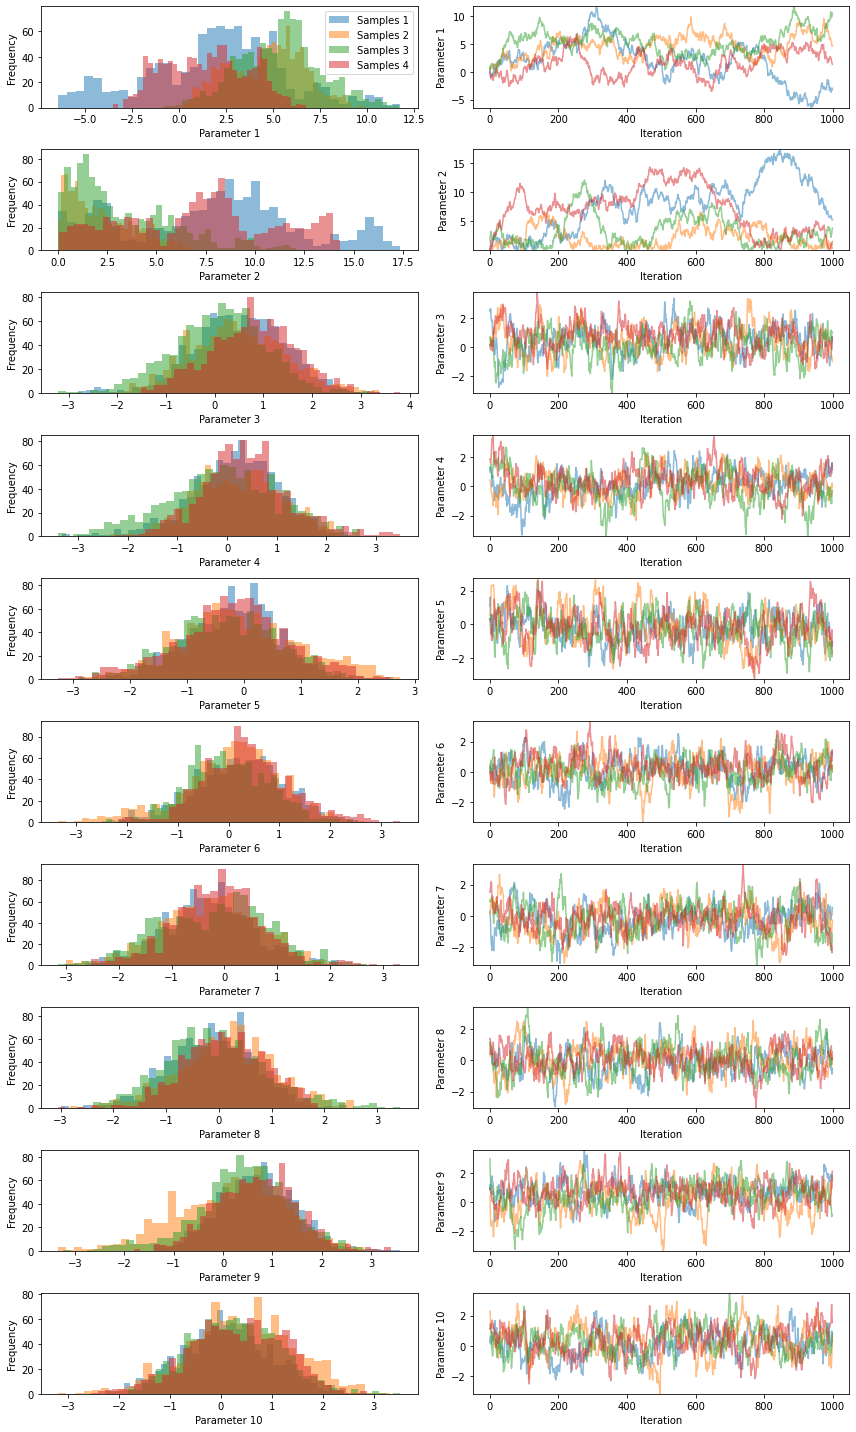

In [104]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

In [ ]:
[[1]]+[abs(np.random.normal(size=10)) for n in range(3)]

# Hierarchical modelling of ODEs

The simplest way of applying this to find ODE parameters for PKPD is to use a one-compartment, bolus dose PKPD example where each of 5 subjects has a different decay constant, k, and individual k values are normally distributed about a group mean.

Any 

We will have many measured samples from each individual test subject, so the problems described in centred statistical models of small datasets shouldn't appear. This means we can use a centred approach without worry.

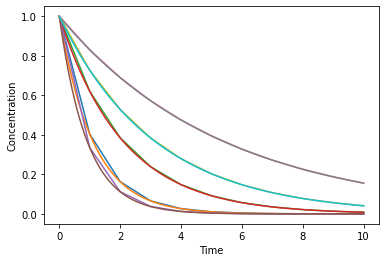

In [156]:
# Parameters
mu = 0.5
tau = 0.3
ks = [abs(n) for n in np.random.normal(mu, tau, 5)]
sigma = 0.1
manytimes = np.linspace(0,10,100)
times = np.linspace(0,10,11)

# A one-compartment PK model is basically an ODE for an exponential decay curve
def onecomp(y, t, k):
    """A one-compartment PK model, aka simple exponential decay
    In
    y: y-axis value
    t: x-axis value
    k: gradient parameter
    
    Out: gradient at the given point
    """
    dydt = -k * y
    return dydt

# You can solve ODEs with the Forward Euler method
def ForwardEuler(func, k, y0, times):
    """Numerically calculate an ODE (forward Euler technique)
    In
    func: function giving the derivative
    k: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

def simulate(func, parameters, y0, times):
    """Numerically calculate an ODE
    In
    func: function giving the derivative
    parameters: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    return scipy.integrate.odeint(func, y0, times, (parameters,))

# This is what the model looks like. We don't actually know these values
actual_values = [simulate(onecomp, k, 1, times) for k in ks]
manyvalues = [simulate(onecomp, k, 1, manytimes) for k in ks]
forwardeuler = [ForwardEuler(onecomp, k, 1, times) for k in ks]
manyeuler = [ForwardEuler(onecomp, k, 1, manytimes) for k in ks]

# Plot the model results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
for k in range(len(actual_values)):
    plt.plot(times, actual_values[k])
    plt.plot(manytimes, manyvalues[k])
plt.show()

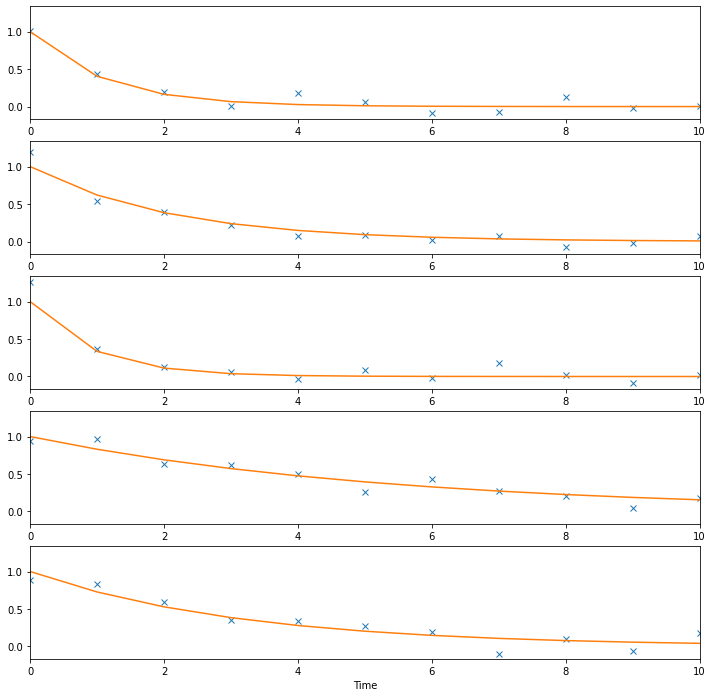

In [157]:
# Make noisy data that we're inferring from. noisy_data is known to us.
sampletimes = np.linspace(0,10,11)
noisy_data = []
noise_magnitude = sigma
fig, axes = plt.subplots(len(actual_values), figsize=(12,12), sharey=True)

for k in range(len(actual_values)):
    noise = np.random.normal(0, noise_magnitude, 11)
    noisy_data.append([a+b for a, b in zip(actual_values[k], noise)])
    axes[k].plot(sampletimes, noisy_data[k], 'x')
    axes[k].plot(times, actual_values[k])
    axes[k].set_xlim([0, 10])
    
plt.xlabel('Time')
plt.show()

So what's the likelihood of a given set of parameters? We have:-
* $y_{jt}$ is the output of our ODE model: the concentration of drug. It varies by time, t, and by person, j. It depends on $k_j$, and the measurements depend on the measurement error, $\sigma$. We know $\sigma$ in advance.
* $k_j$ is the parameter of our ODE model: the decay constant of the ODE. It is different for each person, j. For each person, it is simply a single scalar taken randomly from a normal distribution, $N(\mu, \tau)$.
* $\mu$ is the mean of all parameters, $k_j$. We do not know it, and we assume that it is drawn from a normal distribution with known mean $\mu_\mu$ and known variance $\sigma_\mu$. This is part of our prior.
* $\tau$ is the variance of all parameters about the mean. Like $\mu$ we do not know it, and its probability distribution forms part of our prior. We assume a half-Cauchy distribution with known mean $\mu_\tau$ and known variance $\sigma_\tau$.

The probability, $\mathcal{P}$, of a set of parameters being the correct ones for measured data, $y_{jt}$, is:-
$$\begin{eqnarray}
\mathcal{P} &=& P(y_{jt}, k_j, \mu, \tau) 
\\&=& \prod_{j=1}^8 \prod_{t=0}^T P(y_{jt}|k_j,\sigma) \cdot P(k_j|\mu,\tau) \cdot P(\mu) \cdot P(\tau)
\end{eqnarray}$$

From this, the log probability is:-
$$\begin{eqnarray}
\mathcal{L} &=& \sum_{j=1}^8 \sum_{t=0}^T \log \bigg( \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_{jt}-k_j)^2}{2\sigma^2}}\bigg) + \log \bigg( \frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(k_j-\mu)^2}{2\tau^2}}\bigg) + \log \bigg( \frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}\bigg) + \log \bigg( \frac{\sigma_\tau^2}{(\tau-\mu_\tau)^2 + \sigma_\tau^2} \bigg)
\end{eqnarray}$$

In [158]:
def loglikelihood_onecomp(x, actual_data):
    mu = x[0]
    tau = x[1]
    ks = x[2:]
    
    # priors
    k_log_prior = pints.GaussianLogPrior(mu, tau)
    mu_log_prior = pints.HalfCauchyLogPrior(0,1)
    tau_log_prior = pints.HalfCauchyLogPrior(0,1)
    
    lk_of_mu = mu_log_prior([mu]) # log probability of mu
    lk_of_tau = tau_log_prior([tau]) # log probability of tau
    
    lk_of_data = 0
    lk_of_k = 0
    for j, proposed_k in enumerate(ks): # for each person j
        lk_of_k += k_log_prior([proposed_k]) # log probability of proposed k given mu & tau
        ys = simulate(onecomp, proposed_k, 1, times)
        for t, y in enumerate(ys): # for each time t
            data_log_prior = pints.GaussianLogPrior(y, sigma)
            lk_of_data += data_log_prior([actual_data[j][t]]) # log probability of data for j & t

    return lk_of_mu + lk_of_tau + lk_of_k + lk_of_data
    
class an_ODE_to_pints(pints.LogPDF):
    def __init__(self):
        self._n_parameters = 7
    def __call__(self, x, y_data=actual_values): 
        return loglikelihood_onecomp(x, y_data)
    def n_parameters(self):
        return self._n_parameters

In [159]:
model = an_ODE_to_pints()

# Propose start parameters, normal distribution but making all negative params +ve
num_threads = 4
start_params = [[abs(n) for n in np.random.normal(1, 1, 7)] for n in range(num_threads)]
    
mcmc = pints.MCMCController(model, num_threads, start_params, method=pints.HaarioBardenetACMC)
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

full_chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0         0         0.5        0:00.0
2     12     0.333     0.333     0.333     0.667      0:00.0
3     16     0.5       0.5       0.5       0.75       0:00.0
100   404    0.257     0.396     0.257     0.248      0:00.7
Initial phase completed.
200   804    0.179     0.259     0.169     0.179      0:01.3
300   1204   0.259     0.312     0.252     0.272      0:01.9
400   1604   0.234414  0.292     0.254     0.254      0:02.5
500   2004   0.232     0.281     0.239521  0.237525   0:03.2
600   2404   0.228     0.268     0.231     0.225      0:03.8
700   2804   0.22      0.258     0.22      0.217      0:04.5
800   3204   0.211     0.241     0.21598   0.208      0:05.1
900   3604   0.211     0.24      0.203     0.211      0:05.7
1000  4004   0.212     0.

[0.9062151140087069, 0.4773159048154704, 1.0935426882628485, 0.18594010945045614, 0.31883133208103087]


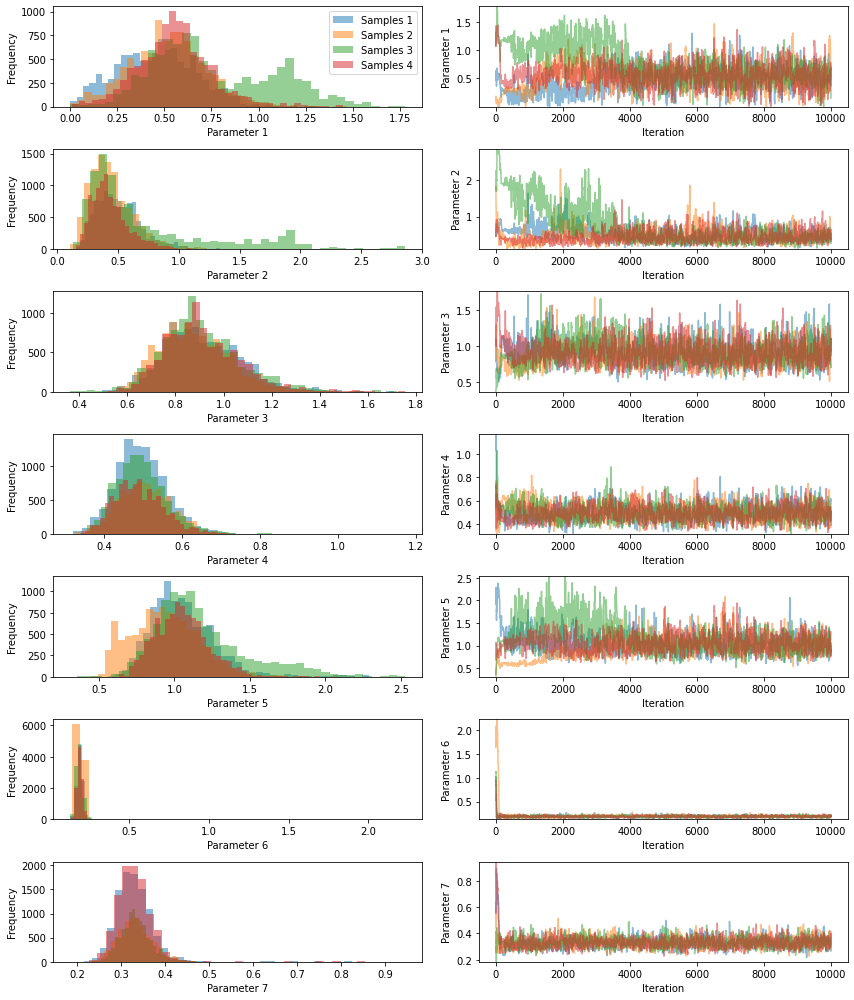

In [160]:
pints.plot.trace(full_chains)
print(ks)
plt.show()